<a href="https://colab.research.google.com/github/Kobajojn/FYRP_U-Net_Architecture/blob/main/U_net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install tacoreader rasterio

Text(0.5, 1.0, 'Human label')

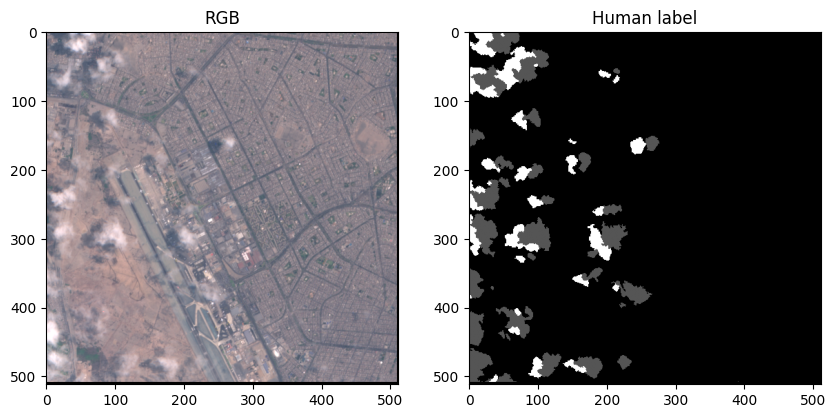

In [2]:
# @Setup and accessing CloudSEN12+
# REWRITE WHOLE SECTION - COPIED

import logging
import matplotlib.pyplot
import matplotlib.pyplot
import numpy
import tacoreader
import rasterio as rio
import torch
import torch.nn as nn

# initalise and set up the logger

# Select one image from the test dataset
ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# Read only one sample
sample_idx = 271
s2_l1c = subset.read(sample_idx).read(0)
s2_label = subset.read(sample_idx).read(1)

# Retrieve the S2 data - EDIT TO BE MORE READABLE
with rio.open(s2_l1c), rio.open(s2_label):
    s2_l1c_data = rio.open(s2_l1c).read(window=rio.windows.Window(0, 0, 512, 512)) / 10_000   # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(s2_label).read(window=rio.windows.Window(0, 0, 512, 512))        #var is a string with links to hugging face

# Graphing image with human determined labels
datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(datapoint_rgb)
ax[0].set_title("RGB")
ax[1].imshow(s2_label_data[0], cmap="gray")
ax[1].set_title("Human label")

In [3]:
# set up logger application
logger = logging.getLogger(__name__)

logging.basicConfig(
    #filename = "logging.txt",  # logger is saved to file instead of value
    encoding = "ASCII",
    format = "%(asctime)s %(name)s %(levelname)s:\t%(message)s",
    level = logging.INFO,
    force = True
)

# Misc Functions

In [4]:
def tensor_info(tensor_input, tensor_name):
  """
  Prints off a list of the tensor's details including:  \
    Datatype, Shape, Size, and the device location stored in memory

  foward() Args:
    tensor_input (tensor) - tensor to be examined.
    tensor_name (string) - a string description of the tensor used for descriptive purposes

  return:
    None
  """
  logger.info(f"Tensor:\t\t\t{tensor_name}")
  logger.info(f"Output Datatype:\t{tensor_input.dtype}")
  logger.info(f"Output Shape:\t\t{tensor_input.shape}")
  logger.info(f"Output Size:\t\t{tensor_input.size()}")
  logger.info(f"Output Device:\t\t{tensor_input.device}"
      f"\n--------------------------------------------------------\n")
  return None

In [5]:
def mash_colour_channel(img):
  """
  Generate a greyscale image of a tensor with more than 3 colour/feature channels. \
    Use primarily for visualisation and debugging purposes of prior transformations.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    None
  """
  # Temporary - converts from Tensor to numpy - TODO: understand why detach is needed
  img = img.detach().numpy()
  z_size = img.shape[0] # Gathers the size of the z or colour element

  # averages out the colour channel elementwise - main transformation of function
  img_no_colour = numpy.mean(a = img, axis = 0)

  # display image dimension characterisitics and print the image
  logger.info(f"The image resolution is {img_no_colour.shape}")
  logger.info(f"The number of colour channels are {z_size}")
  matplotlib.pyplot.gray() # place the image output into greyscale
  matplotlib.pyplot.imshow(img_no_colour)
  matplotlib.pyplot.show()
  return None

# Encoder Layer

In [6]:
device = 'cpu'

# ENCODER LAYER - going "down the U"; i.e decreasing the resolution at the for more colour channels

class conv_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Used in both encoder and decoder segments.
    Applies a convolution (3x3) and ReLU to the image twice to the image.
    1x convolution reduces the resolution by 2 pixels and 2x the colour channels.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor float32) - The output image after transformations.
  """
  def __init__ (self, channels_in, up_sample = True): # Parameters go here!
    super().__init__()

    if up_sample:
      out_channels = channels_in * 2
    else:
      out_channels = int(channels_in / 2)

    # Convolution 1 - a sliding window function
    self.conv1 = nn.Conv2d(
        in_channels = channels_in,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        # padding = 1,                    # padded with zeros to ensure dimensions are always even
        # padding_mode = 'zeros',         # [30] recommends an unpadded convolution
        # bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    )
    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = out_channels,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    )
    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU()

  def forward(self, img):
    output = self.conv1(img)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.relu(output)
    return output


class encoder_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Main core segment of the encoder stage.
    Applies a convolution (3x3) and ReLU to the image twice then (2x2) pool to the image.

    1x pooling downsamples the resolution by x0.5.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    postpool_output (tensor float32) - The output image after pooling.
    prepool_output (tensor float32) - The output image before pooling. Used in concatenation.
  """
  def __init__ (self): # Parameters go here!
    super().__init__()

    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
    )

  def forward(self, img, channels_in):
    conv_forward = conv_layer(channels_in = channels_in)
    output = conv_forward(img)

    prepool_output = output
    postpool_output = self.pooling(output) # Final transformation to image

    return postpool_output, prepool_output


# Decoder Layer

In [7]:
# DECODER LAYER - going "up the U"; i.e increasing the resolution at the expense of less colour channels

class decoder_layer(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Apply a (2x2) "deconvolution" transformation to counteract the impacts of pooling and convolution.
    Then a "concatenation_feature()" is applied to double colour channel size.
    The main building block of the decoder side of the U-net model.
    1x deconvolution increases the resolution 2x and the colour channels by x0.5.
    1x "concatenation_features()" to the image (doubles colour channel)

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.
    img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
      Image format is [z, x, y] or [w, u, v]

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, channels_deconv_in):
    super().__init__()

    self.deconv1 = nn.ConvTranspose2d(
        in_channels = channels_deconv_in,
        out_channels = int(channels_deconv_in / 2),
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    )

  def crop_and_concat(self, img_decoder, img_encoder_skip):
    """
    Doubles the feature channels of its input image.
      Crops prepool_output from the encoder layer and then concatenates its colour/
      feature channels with the decoder's respective deconvoluted image.

    Args:
      img_decoder (tensor float32) - Deconvoluted image from decoder side.
        Image format is [z, x, y] or [w, u, v].
        Only works if [x, y] dimensions are EVEN.
      img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
        Image format is [z, x, y] or [w, u, v]

    Returns:
      img_concat (tensor float32) - image with double the inputs colour channels
    """
    # Determining the range of the cropping
    size_difference =  img_encoder_skip.shape[1] - img_decoder.shape[1]
    logger.debug(f"size_difference = {size_difference}")
    logger.debug(f"img_encoder_skip.shape = {img_decoder.shape}")
    logger.debug(f"img_decoder.shape = {img_decoder.shape}")

    lower_range = int(size_difference / 2)
    upper_range = img_decoder.shape[1] + lower_range

    # Only works if dimensions are even
    if size_difference % 2 == 0:
      logger.debug(f"The image dimensions are EVEN. Thus cropping can be applied.")

      # Crop the encoded image to fit the resolution of the reduced (in dimensions) decoded image
      img_encoder_crop = img_encoder_skip[:, lower_range:upper_range, lower_range:upper_range]
      # tensor_info(img_decoder, "[ORIGINAL] img_decoder")
      # tensor_info(img_encoder_crop, "[CROPPED] img_encoder_crop")

      # concatenate the colour/feature channels of the encoder and decoder imgs.
      img_concat = torch.cat(tensors = (img_decoder, img_encoder_crop), dim = 0)
      # tensor_info(img_concat, "[COMBINED] img_concat (combined colour channels)")
      # mash_colour_channel(img_concat)

      return img_concat

    else:
      logger.info(f"The image dimensions are ODD. Thus cropped can NOT be applied."
        f"Please crop the image for a EVEN dimension.")
      return None

  def forward(self, img_decoder, img_encoder_skip, channels_in):
    # deconvolute (decrease features, increasing x,y size) + crop and concatenate (x2 feature channels)
    output = self.deconv1(img_decoder)
    output = self.crop_and_concat(img_decoder = output, img_encoder_skip = img_encoder_skip)

    # Apply 2x convolutions + 2x ReLU
    conv_layer_1 = conv_layer(channels_in = channels_in, up_sample = False)
    output = conv_layer_1(output)
    return output

# Bringing it all together

In [8]:
""" ---VARIABLE NAMING NOMENCLATURE:---
- Alphabetical images correspond to which layer the image was generated on.
e.g. B_pooled is on layer 2.
- "X_pooled" are images generated with 2x2 pooling applied.
- "X_concat" are images generated before pooling. This are for concatenation later.
"""

class u_net(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Applies the U-net architecture complete via prior defined piecemeal functions.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, ):
    super().__init__()
    # ---------------------------------------------------------
    # Instantiate and initialise each layer
    # Encoder Layer instantiation
    self.encoder_layer_1 = encoder_layer().to(device)
    # Bottleneck Layer instantiation
    self.bottleneck_layer = conv_layer(channels_in = 208).to(device)
    # Decoders instantiation
    self.decoder_layer_0 = decoder_layer(channels_deconv_in = 416).to(device)
    self.decoder_layer_1 = decoder_layer(channels_deconv_in = 208).to(device)
    self.decoder_layer_2 = decoder_layer(channels_deconv_in = 104).to(device)
    self.decoder_layer_3 = decoder_layer(channels_deconv_in = 52).to(device)
    self.decoder_layer_4 = decoder_layer(channels_deconv_in = 26).to(device)
    # Final Layer instantiation
    self.final_layer = conv_layer(channels_in = 26, up_sample = False).to(device)
    # ---------------------------------------------------------

  def forward(self, img):

    # Apply image to instantiated layers
    # Encoder layer
    A_pooled, A_concat = self.encoder_layer_1(img, channels_in = 13)
    B_pooled, B_concat = self.encoder_layer_1(A_pooled, channels_in = 26)
    C_pooled, C_concat = self.encoder_layer_1(B_pooled, channels_in = 52)
    D_pooled, D_concat = self.encoder_layer_1(C_pooled, channels_in = 104)

    # Bottleneck layer
    E_bottleneck = self.bottleneck_layer(D_pooled)

    # Decoder Layer
    D_deconv = self.decoder_layer_0(
        img_decoder = E_bottleneck,
        img_encoder_skip = D_concat,
        channels_in = 416
    )
    C_deconv = self.decoder_layer_1(
        img_decoder = D_deconv,
        img_encoder_skip = C_concat,
        channels_in = 208
    )
    B_deconv = self.decoder_layer_2(
        img_decoder = C_deconv,
        img_encoder_skip = B_concat,
        channels_in = 104
    )
    A_deconv = self.decoder_layer_3(
        img_decoder = B_deconv,
        img_encoder_skip = A_concat,
        channels_in = 52
    )
    # Final Layer
    Final_output = self.final_layer(A_deconv)
    return Final_output

2025-09-12 10:38:44,308 __main__ INFO:	The image resolution is (320, 320)
2025-09-12 10:38:44,309 __main__ INFO:	The number of colour channels are 13


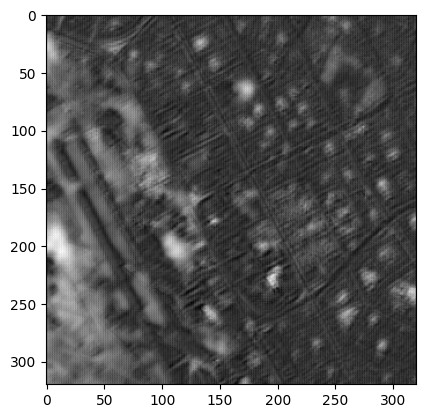

In [37]:
# Image preprocessing
s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(torch.float32)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(device)
# Crop image such that after 8 convolutions are 4 poolings, the dimensions are always even
s2_l1c_data_tensor = s2_l1c_data_tensor[:, 0:508, 0:508]

# Apply everything via the U-net architecture
u_net_arch = u_net()
img_out = u_net_arch(s2_l1c_data_tensor)

mash_colour_channel(img_out)

# Training Stage Sandpit

In [28]:
# Sandpit - for debugging and troubleshooting

# Seed for randomness - keeps the initial parameter values consistent
torch.manual_seed(27)

# Sanity Check: Display u-net architecture's parameters
u_net_arch_0 = u_net()
logger.debug(f"{list(u_net_arch_0.parameters()) = }")

2025-09-12 10:38:16,576 __main__ INFO:	list(u_net_arch.parameters()) = [Parameter containing:
tensor([[[[ 1.3916e-02, -1.1613e-02, -7.6962e-03],
          [-7.0198e-03, -2.2336e-03,  1.9612e-02],
          [-1.2495e-02, -1.0665e-02, -7.4330e-04]],

         [[ 1.2204e-02, -2.7733e-04,  1.9472e-02],
          [ 6.2786e-03, -1.2666e-02,  2.2825e-02],
          [ 3.7849e-04, -1.4006e-02,  5.7711e-03]],

         [[-1.7349e-02, -1.7865e-02,  5.6065e-03],
          [-1.6193e-02,  6.0649e-03,  2.0669e-03],
          [ 1.1779e-02, -2.0244e-02, -1.9202e-02]],

         ...,

         [[-1.6029e-02, -2.1137e-02, -1.7240e-02],
          [ 1.8564e-02, -3.3437e-03,  1.8913e-02],
          [ 1.6803e-03,  1.9702e-03, -9.3929e-03]],

         [[-9.6108e-03, -8.8981e-03,  1.1831e-02],
          [-2.0164e-02,  8.4101e-03,  3.9331e-03],
          [ 2.0388e-03, -1.6983e-03, -1.5314e-02]],

         [[-4.5110e-03,  1.9167e-02,  1.5320e-02],
          [ 7.5544e-03, -1.5721e-02,  1.8136e-02],
          [ 1.

# Training Stage

In [11]:
# The code done here follows the example methodologies shown in introduction to PyTorch

# Problem breakdown and requirements:

# Need to import training data
# -> breakdown into training and testing datasets
# -> datasets must be cropped and converted into valid filetype
# Need to import labels
# -> datatype?
# -> labels must be cropped and converted into valid filetype

# Need to evaluate success and labels

# WORK IN PROGRESS
# Define the working datasets:
# TODO CHECK DIMENSIONS
# imported datasets are: img [z,x,y,i?], labels [x,y,i?]

# Relies on assumptions of the quality of the imported data
img_crop, labels_crop = img_in[:, 0:508, 0:508], labels_in[0:508, 0:508]

train_dataset_amount = int(img_cropped.shape[3] * 0.8) # get final dimension - should be how many datasets
img_train, labels_train = img_in[:, :, :, :train_dataset_amount], labels_in[:, :, :train_dataset_amount]
img_test, labels_test = img_in[:, :, :, train_dataset_amount:], labels_in[:, :, train_dataset_amount:]

# TODO create method of visualising "cloud cover guesses"


NameError: name 'img_in' is not defined

In [ ]:
TRAINING_LENGTH = 200 # CONTROLS NUMBER OF TRAINING CYCLES


for epoch in range(TRAINING_LENGTH):
  u_net.train() # In Training Mode - Default

In [ ]:
# Print off images and their respective dimensions
"""
# Visualising the results along with their respective dimensions

# Print off image with the colour channels combined
# First Image
mash_colour_channel(s2_l1c_data_tensor) # Original image

# Encoder Images
mash_colour_channel(A_pooled)
mash_colour_channel(B_pooled)
mash_colour_channel(C_pooled)
mash_colour_channel(D_pooled)

mash_colour_channel(E_bottleneck)

# Decoder Images
mash_colour_channel(D_deconv)
mash_colour_channel(C_deconv)
mash_colour_channel(B_deconv)
mash_colour_channel(A_deconv)

# Final image
mash_colour_channel(Final_output)

# Encoder
tensor_info(s2_l1c_data_tensor, "layer 0 - s2_l1c_data_tensor")
tensor_info(A_concat, "encoder_layer_0.5 - A_concat")
tensor_info(A_pooled, "encoder_layer_1 - A_pooled")
tensor_info(B_concat, "encoder_layer_1.5 - B_concat")
tensor_info(B_pooled, "encoder_layer_2 - B_pooled")
tensor_info(C_concat, "encoder_layer_2.5 - C_concat")
tensor_info(C_pooled, "encoder_layer_3 - C_pooled")
tensor_info(D_concat, "encoder_layer_4.5 - D_concat")
tensor_info(D_pooled, "encoder_layer_4 - D_pooled") # size [208, 28, 28] - final layer

tensor_info(E_bottleneck, "[BOTTLENECK] encoder_layer_5")

# Decoder
tensor_info(D_deconv, "decoder_layer_4 - D_deconv")
tensor_info(C_deconv, "encoder_layer_3 - C_deconv")
tensor_info(B_deconv, "encoder_layer_2 - B_deconv")
tensor_info(A_deconv, "encoder_layer_1 - A_deconv")
tensor_info(Final_output, "Final output")
"""

## todo:
1. *work out how to transfer images and visualise progress*
2. determine required images and what I should use
3. being to save progress
4. make the model tech agnostic
5. Get a logger setup - requires a working file directory
```
import logging
self.logger = logging.getLogger(__name__)
```
## todo big picture:
1. *get rough model working*
2. *build the Unet model*

##Useful knowledge:
1. keyboard shortcut to comment and uncomment out things is ctrl + "/"
2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512
3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information
